In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from IPython.display import Audio
import IPython
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

SAMPLE_RATE = 44100

In [2]:
# set up variables for training

# make a fix file size
fixed_size  = tuple((500,500))

#train path 
train_path = "FolderFrames/KermitAudioTrainingSet/KermitTrainingSet"

# no of trees for Random Forests
num_tree = 100

# bins for histograms 
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same result 
seed = 9

In [3]:
# features description -1:  mfcc
def get_mfcc(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.mfcc(b, sr = SAMPLE_RATE, n_mfcc=40)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [4]:
# feature-descriptor -2: spectral centroid
def get_spectral_centroid(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.spectral_centroid(b, sr=SAMPLE_RATE)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [5]:
# feature-descriptor -3: zero_crossing_rate
def get_zero_crossing_rate(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.zero_crossing_rate(b)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [6]:
# feature-descriptor -4: tonal centroid features (tonnetz)
def get_tonnetz(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        y = librosa.effects.harmonic(b)
        gmm = librosa.feature.tonnetz(y, sr=SAMPLE_RATE)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [7]:
# feature-descriptor -5: Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.
def get_poly(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        S = np.abs(librosa.stft(b))
        gmm = librosa.feature.poly_features(S=S, order=0)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [8]:
# feature-descriptor -5: spectral_flatness
def get_spectral_flatness(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.spectral_flatness(b)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [9]:
# feature-descriptor -5: spectral_rolloff
def get_spectral_rolloff(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.spectral_rolloff(b)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [10]:
# feature-descriptor -6: root mean square
def get_rms(name):
    b, _ = librosa.core.load(name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.rms(b)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [11]:
# get the training data labels 
train_labels = os.listdir(train_path)

# sort the training labesl 
train_labels.sort()
print(train_labels)

# empty list to hold feature vectors and labels 
global_features = []
labels = []

i, j = 0, 0 
k = 0

['NoKermit', 'YesKermit']


In [12]:
# feature extraction

# lop over the training data sub folder 
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
        
    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)
        
        if file is not None:
            fv_mfcc = get_mfcc(file)
            fv_zero_crossing_rate = get_zero_crossing_rate(file)
            fv_spectral_centroid = get_spectral_centroid(file)
            fv_spectral_rolloff = get_spectral_rolloff(file)
            #fv_tonnetz = get_tonnetz(file)
            fv_spectral_flatness = get_spectral_flatness(file)
            fv_rms = get_rms(file)
            fv_poly = get_poly(file)

        # Concatenate global features
        global_feature = np.hstack([fv_mfcc, fv_zero_crossing_rate, fv_spectral_rolloff, fv_spectral_flatness, fv_rms, fv_poly])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1
    print("[STATUS] processed folder: {}".format(current_label))
    j += 1

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: NoKermit
[STATUS] processed folder: YesKermit
[STATUS] completed Global Feature Extraction...


In [13]:
# train the forest

# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...{}")
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('./FolderFrames/kermitAudioOutput/featuresAudioKermit.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('./FolderFrames/kermitAudioOutput/labelsAudioKermit.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (1550, 90)
[STATUS] training Labels (1550,)
[STATUS] training labels encoded...{}
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 ... 1 1 1]
[STATUS] target labels shape: (1550,)
[STATUS] end of training..


In [14]:
# import the feature vector and trained labels

h5f_data = h5py.File('./FolderFrames/kermitAudioOutput/featuresAudioKermit.h5', 'r')
h5f_label = h5py.File('./FolderFrames/kermitAudioOutput/labelsAudioKermit.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

In [15]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

In [16]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

clf_pred = clf.predict(trainDataGlobal)
print(metrics.classification_report(trainLabelsGlobal,clf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1288
           1       1.00      0.88      0.94       107

    accuracy                           0.99      1395
   macro avg       1.00      0.94      0.97      1395
weighted avg       0.99      0.99      0.99      1395



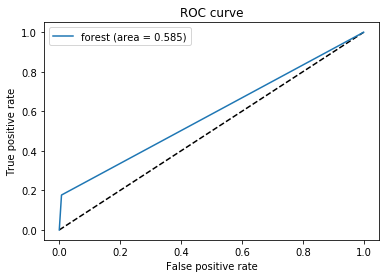

In [17]:
# Evaluate (ROC curve)

y_pred_forest = clf.predict(testDataGlobal).ravel()
fpr_forest, tpr_forest, thresholds_forest = roc_curve(testLabelsGlobal, y_pred_forest)

auc_forest = auc(fpr_forest, tpr_forest)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_forest, tpr_forest, label='forest (area = {:.3f})'.format(auc_forest))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [18]:
# path to test data
test_path = "./FolderFrames/KermitAudioTrainingSet/kermitTestSet"

# loop through the test images
#for file in glob.glob(test_path + "/*.jpg"):
for file in os.listdir(test_path):    

    file = test_path + "/" + file
    #print(file)
    audio_data = librosa.load(file)
    # read the image
    #image = cv2.imread(file)

    # resize the image
    #image = cv2.resize(image, fixed_size)

    # Global Feature extraction
    fv_mfcc = get_mfcc(file)
    fv_zero_crossing_rate = get_zero_crossing_rate(file)
    fv_spectral_centroid = get_spectral_centroid(file)
    fv_spectral_rolloff = get_spectral_rolloff(file)
    #fv_tonnetz = get_tonnetz(file)
    fv_spectral_flatness = get_spectral_flatness(file)
    fv_rms = get_rms(file)
    fv_poly = get_poly(file)

    # Concatenate global features
    global_feature = np.hstack([fv_mfcc, fv_zero_crossing_rate, fv_spectral_rolloff, fv_spectral_flatness, fv_rms, fv_poly])
    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # show predicted label on image
    #cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.show()
    if prediction:
        print("YES Kermit speaking:")
        
    else:
        print("NO Kermit not speaking:")
    IPython.display.display(IPython.display.Audio(file, rate=250))
    print("-----------------------------------------------")
    

NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
NO Kermit not speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
YES Kermit speaking:


-----------------------------------------------
